### In this new : 
I am using the dataset with the 1:1's !

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from icecream import ic
import statsmodels.api as sm 
from statsmodels.regression import linear_model
from utils import residual_vs_covariate, process_data, deviance_analysis
import seaborn as sb

In [2]:
data = pd.read_csv('../data/df-time-agg.csv')
data = data[data["person"]!="ingeborgR"]
data = data[(data["person"] != "adamF") | (data["coin"] != "0.05EUR") | (data["agg"] != 84)]


data_expanded = data.copy()
data_expanded['r'] = data["heads_heads"]+(data['N_start_tails_up']-data["tails_heads"])
data_expanded['m'] = data['N_start_tails_up']+data['N_start_heads_up']
data_expanded['rom'] = data_expanded['r'] / data_expanded['m']
data_expanded['weights'] = (4*data_expanded['m'])

print(len(data_expanded))
print(data_expanded)

3409
      heads_heads  tails_heads  N_start_heads_up  N_start_tails_up  same_side  \
0              28           20                48                52         60   
1              19           24                43                57         52   
2              20           28                48                52         44   
3              34           20                54                46         60   
4              20           26                46                54         48   
...           ...          ...               ...               ...        ...   
3490           27           27                53                47         47   
3491           17           27                43                57         47   
3492           27           22                48                52         57   
3493           23           22                46                54         55   
3494           28           25                53                47         50   

        N        perso

In [3]:
# just a preliminary in order to rule out the rest :

WLS_model_no_interactions = linear_model.WLS.from_formula(formula="(rom) ~ 1+C(person)+agg+C(coin)",weights=data_expanded["weights"]/np.mean(data_expanded["weights"]),  data=data_expanded) 
WLS_model_with_interactions = linear_model.WLS.from_formula(formula="(rom) ~ 1+C(person)+agg+C(coin)+C(person):C(coin)",weights=data_expanded["weights"]/np.mean(data_expanded["weights"]),  data=data_expanded) 

result_no_interactions = WLS_model_no_interactions.fit()
result_with_interactions = WLS_model_with_interactions.fit()
print(f"\nAIC for the WLS_0: {result_no_interactions.aic:.2f}")
print(f"\nAIC for the WLS_1: {result_with_interactions.aic:.2f}")


AIC for the WLS_0: -10419.17

AIC for the WLS_1: -10324.40


In [4]:
WLS_model_0 = linear_model.WLS.from_formula(formula="(rom) ~ 1",weights=data_expanded["weights"]/np.mean(data_expanded["weights"]), data=data_expanded)
WLS_model_1 = linear_model.WLS.from_formula(formula="(rom) ~ 1+C(person)",weights=data_expanded["weights"]/np.mean(data_expanded["weights"]),  data=data_expanded)
WLS_model_2 = linear_model.WLS.from_formula(formula="(rom) ~ 1+C(person)+agg",weights=data_expanded["weights"]/np.mean(data_expanded["weights"]),  data=data_expanded) # Best AIC 
WLS_model_3 = linear_model.WLS.from_formula(formula="(rom) ~ 1+C(person)+agg+C(coin)",weights=data_expanded["weights"]/np.mean(data_expanded["weights"]),  data=data_expanded) 
WLS_model_4 = linear_model.WLS.from_formula(formula="(rom) ~ 1+C(person)+agg+C(person):C(coin)",weights=data_expanded["weights"]/np.mean(data_expanded["weights"]),  data=data_expanded) # Best LRT
result_WLS_0 = WLS_model_0.fit()
result_WLS_1 = WLS_model_1.fit()
result_WLS_2 = WLS_model_2.fit()
result_WLS_3 = WLS_model_3.fit()
result_WLS_4 = WLS_model_4.fit()
print(f"\nAIC for the WLS_0: {result_WLS_0.aic:.2f}")
print(f"\nAIC for the WLS_1: {result_WLS_1.aic:.2f}")
print(f"\nAIC for the WLS_2: {result_WLS_2.aic:.2f}")
print(f"\nAIC for the WLS_3: {result_WLS_3.aic:.2f}")
print(f"\nAIC for the WLS_4: {result_WLS_4.aic:.2f}")
# lower AIC is better !
# We select model 2 with persons only !


AIC for the WLS_0: -10288.62

AIC for the WLS_1: -10435.50

AIC for the WLS_2: -10448.38

AIC for the WLS_3: -10419.17

AIC for the WLS_4: -10324.40


In [5]:
minimal_aic = min(result_WLS_0.aic, result_WLS_1.aic, result_WLS_2.aic,  result_WLS_3.aic, result_WLS_4.aic)

# Create a table for model comparison
model_data = {
    "Model Formula (RHS)": [
        "1",
        "1 + C(person)",
        "1 + C(person) + agg",
        "1 + C(person) + agg + C(coin)",
        "1 + C(person) + agg + C(person):C(coin)"
    ],
    "AIC": [
        result_WLS_0.aic - minimal_aic,
        result_WLS_1.aic - minimal_aic,
        result_WLS_2.aic - minimal_aic,
        result_WLS_3.aic - minimal_aic,
        result_WLS_4.aic - minimal_aic,
    ],
}

# Create a DataFrame
comparison_table = pd.DataFrame(model_data)

# Generate LaTeX table
table_latex = comparison_table.to_latex(
    index=False,
    float_format="{:.2f}".format,
    caption="Model comparison based on AIC values.",
    label="tab:model-comparison",
    position="htb",
    column_format="lc"
)

# Modify the LaTeX string to add centering
caption_index = table_latex.find(r"\caption")
table_latex = table_latex[:caption_index] + r"\centering" + "\n" + table_latex[caption_index:]

# Display the LaTeX table
print(table_latex)

\begin{table}[htb]
\centering
\caption{Model comparison based on AIC values.}
\label{tab:model-comparison}
\begin{tabular}{lc}
\toprule
Model Formula (RHS) & AIC \\
\midrule
1 & 159.76 \\
1 + C(person) & 12.89 \\
1 + C(person) + agg & 0.00 \\
1 + C(person) + agg + C(coin) & 29.21 \\
1 + C(person) + agg + C(person):C(coin) & 123.98 \\
\bottomrule
\end{tabular}
\end{table}



#### Here to do the final ANOVA-AIC for WLS

In [6]:
table = sm.stats.anova_lm(result_WLS_3, typ=2)
print(table)
row_labels = table.index.tolist()
row_labels[1], row_labels[2] = row_labels[2], row_labels[1] # Swap r2 and r3 labls
table.iloc[[1, 2]] = table.iloc[[2, 1]].values  # Swap the values of rows
table.index = row_labels  # Assign the new index order

empty_row = pd.DataFrame([{}], columns=table.columns)  # Empty row
table = pd.concat([empty_row, table], ignore_index=True)
aic_differences = [result_WLS_0.aic - minimal_aic, result_WLS_1.aic - minimal_aic,result_WLS_2.aic - minimal_aic, result_WLS_3.aic - minimal_aic, 0]
# Add the column to the DataFrame
table["Delta AIC"] = aic_differences
print(table)
comparison_table = table

# Generate LaTeX table
table_latex = comparison_table.to_latex(
    index=False,
    float_format="{:.2f}".format,
    formatters={'PR(>F)': lambda x: f'{x:.2e}'},
    caption="Model comparison based on AIC values.",
    label="tab:model-comparison",
    position="htb",
    column_format="lc"
)

# Modify the LaTeX string to add centering
caption_index = table_latex.find(r"\caption")
table_latex = table_latex[:caption_index] + r"\centering" + "\n" + table_latex[caption_index:]

# Display the LaTeX table
print(table_latex)

'''
\begin{table}[htb]
\centering
\caption{ANOVA (type II)}
\label{tab:model-comparison}
\begin{tabular}{lccccc}
\toprule
Term & RSS & df & F & PR(>F) & Delta AIC \\
\midrule
1 & - & - & - & - & 159.76 \\
person & 213.78 & 46.00 & 4.31 & 0.00 & 12.89 \\
coin & 7.65 & 1.00 & 7.10 & 0.01 & 0.00 \\
agg & 57.95 & 42.00 & 1.28 & 0.11 & 29.21 \\
Residual & 3576.62 & 3319.00 & - & - & 0.00 \\
\bottomrule
\end{tabular}
\end{table}
'''



             sum_sq      df         F        PR(>F)
C(person)  0.532488    46.0  4.312697  4.467021e-20
C(coin)    0.144344    42.0  1.280398  1.070507e-01
agg        0.019058     1.0  7.100152  7.745041e-03
Residual   8.908624  3319.0       NaN           NaN
     sum_sq      df         F        PR(>F)   Delta AIC
0       NaN     NaN       NaN           NaN  159.764090
1  0.532488    46.0  4.312697  4.467021e-20   12.885935
2  0.019058     1.0  7.100152  7.745041e-03    0.000000
3  0.144344    42.0  1.280398  1.070507e-01   29.207756
4  8.908624  3319.0       NaN           NaN    0.000000
\begin{table}[htb]
\centering
\caption{Model comparison based on AIC values.}
\label{tab:model-comparison}
\begin{tabular}{lc}
\toprule
sum_sq & df & F & PR(>F) & Delta AIC \\
\midrule
NaN & NaN & NaN & NaN & 159.76 \\
0.53 & 46.00 & 4.31 & 4.47e-20 & 12.89 \\
0.02 & 1.00 & 7.10 & 7.75e-03 & 0.00 \\
0.14 & 42.00 & 1.28 & 1.07e-01 & 29.21 \\
8.91 & 3319.00 & NaN & NaN & 0.00 \\
\bottomrule
\end{tabular

<>:34: SyntaxWarning: invalid escape sequence '\c'
<>:34: SyntaxWarning: invalid escape sequence '\c'
C:\Users\Tobia\AppData\Local\Temp\ipykernel_21852\2585815053.py:34: SyntaxWarning: invalid escape sequence '\c'
  '''


'\n\x08egin{table}[htb]\n\\centering\n\\caption{ANOVA (type II)}\n\\label{tab:model-comparison}\n\x08egin{tabular}{lccccc}\n\toprule\nTerm & RSS & df & F & PR(>F) & Delta AIC \\\n\\midrule\n1 & - & - & - & - & 159.76 \\\nperson & 213.78 & 46.00 & 4.31 & 0.00 & 12.89 \\\ncoin & 7.65 & 1.00 & 7.10 & 0.01 & 0.00 \\\nagg & 57.95 & 42.00 & 1.28 & 0.11 & 29.21 \\\nResidual & 3576.62 & 3319.00 & - & - & 0.00 \\\n\x08ottomrule\n\\end{tabular}\n\\end{table}\n'

In [7]:
# LRT 

#model 0: "1",     
#model 1: "1 + C(person)",      
#model 2: "1 + C(person) + agg", better than 3          
#model 3: "1 + C(person) + agg + C(coin)",       
#model 4: "1 + C(person) + agg + C(person):C(coin)"      

print(result_WLS_1.compare_lr_test(result_WLS_0, large_sample=False)) # 1 is better

print(result_WLS_2.compare_lr_test(result_WLS_1, large_sample=False)) # 2 is better

print(result_WLS_3.compare_lr_test(result_WLS_2, large_sample=False)) # 2 is better

print(result_WLS_4.compare_lr_test(result_WLS_2, large_sample=False)) # 2 is better


# Table for LRT tests
_,LRT_1_0,_ = result_WLS_1.compare_lr_test(result_WLS_0, large_sample=False)
_,LRT_2_1,_  = result_WLS_2.compare_lr_test(result_WLS_1, large_sample=False)
_,LRT_3_2,_  = result_WLS_3.compare_lr_test(result_WLS_2, large_sample=False)
_,LRT_4_2,_  = result_WLS_4.compare_lr_test(result_WLS_2, large_sample=False)

# Create a table for model comparison
model_data = {
    "Tested Model": [
        "1 + C(person)",  # Model 1
        "1 + C(person) + agg",  # Model 2
        "1 + C(person) + agg + C(coin)",  # Model 3
        "1 + C(person) + agg + C(person):C(coin)"  # Model 4
    ],

    "Restricted Model": [
        "1",  # Compared to Model 0
        "1 + C(person)",  # Compared to Model 1
        "1 + C(person) + agg",  # Compared to Model 2
        "1 + C(person) + agg",  # Compared to Model 2
    ],

    "p-value": [
        LRT_1_0,
        LRT_2_1,
        LRT_3_2,
        LRT_4_2,
    ],
}

lrt_comparison_table = pd.DataFrame(model_data)
print('Table for LRTs : ')
LRT_string = lrt_comparison_table.to_latex(index=True, 
                columns=['Tested Model', 'Restricted Model', 'p-value'], 
                header=['Tested model', 'Restricted Model', 'p-value'],
                float_format='{:.2f}'.format,
                caption='LRTs table',
                label='tab:LRT-model-comparison',
                position='htb',
                column_format='lcc')
caption_index = LRT_string.find(r'\caption')
deviance_string = LRT_string[:caption_index] + r'\centering' + '\n' + LRT_string[caption_index:]
print(LRT_string)

'''
\begin{table}[htb]
\caption{LRTs table}
\label{tab:LRT-model-comparison}
\begin{tabular}{lcc}
\toprule
 & Tested model & Restricted Model & p-value \\
\midrule
0 & 1 + C(person) & 1 & 7.28e-28 \\
1 & 1 + C(person) + agg & 1 + C(person) & 1.14e-4 \\
2 & 1 + C(person) + agg + C(coin) & 1 + C(person) + agg & 8.91e-2 \\
3 & 1 + C(person) + agg + C(person):C(coin) & 1 + C(person) + agg & 2.04e-2 \\
\bottomrule
\end{tabular}
\end{table}
'''

<>:62: SyntaxWarning: invalid escape sequence '\c'
<>:62: SyntaxWarning: invalid escape sequence '\c'
C:\Users\Tobia\AppData\Local\Temp\ipykernel_21852\1172874183.py:62: SyntaxWarning: invalid escape sequence '\c'
  '''


(np.float64(238.87815532385503), np.float64(7.28039793891565e-28), np.float64(46.0))
(np.float64(14.885934995327261), np.float64(0.00011421137146345186), np.float64(1.0))
(np.float64(54.7922437198813), np.float64(0.0891482226803654), np.float64(42.0))
(np.float64(202.01628789149981), np.float64(0.020406475246802103), np.float64(163.0))
Table for LRTs : 
\begin{table}[htb]
\caption{LRTs table}
\label{tab:LRT-model-comparison}
\begin{tabular}{lcc}
\toprule
 & Tested model & Restricted Model & p-value \\
\midrule
0 & 1 + C(person) & 1 & 0.00 \\
1 & 1 + C(person) + agg & 1 + C(person) & 0.00 \\
2 & 1 + C(person) + agg + C(coin) & 1 + C(person) + agg & 0.09 \\
3 & 1 + C(person) + agg + C(person):C(coin) & 1 + C(person) + agg & 0.02 \\
\bottomrule
\end{tabular}
\end{table}



'\n\x08egin{table}[htb]\n\\caption{LRTs table}\n\\label{tab:LRT-model-comparison}\n\x08egin{tabular}{lcc}\n\toprule\n & Tested model & Restricted Model & p-value \\\n\\midrule\n0 & 1 + C(person) & 1 & 7.28e-28 \\\n1 & 1 + C(person) + agg & 1 + C(person) & 1.14e-4 \\\n2 & 1 + C(person) + agg + C(coin) & 1 + C(person) + agg & 8.91e-2 \\\n3 & 1 + C(person) + agg + C(person):C(coin) & 1 + C(person) + agg & 2.04e-2 \\\n\x08ottomrule\n\\end{tabular}\n\\end{table}\n'

### ANOVA of selected model

In [8]:
table = sm.stats.anova_lm(result_WLS_3, typ=2) 
print(table)
print('Table for models comparison : ')
deviance_string = table.to_latex(index=True, 
                columns=['sum_sq', 'df', 'F', 'PR(>F)'], 
                header=['SS', 'DoF', 'F-statistic', 'p-value'],
                #formatters={'formula': lambda x: r'\texttt{'+x+r'}'},
                float_format='{:.2f}'.format,
                caption='ANOVA table',
                label='tab:model-comparison',
                position='htb',
                column_format='lcccc')
caption_index = deviance_string.find(r'\caption')
deviance_string = deviance_string[:caption_index] + r'\centering' + '\n' + deviance_string[caption_index:]
print(deviance_string)

             sum_sq      df         F        PR(>F)
C(person)  0.532488    46.0  4.312697  4.467021e-20
C(coin)    0.144344    42.0  1.280398  1.070507e-01
agg        0.019058     1.0  7.100152  7.745041e-03
Residual   8.908624  3319.0       NaN           NaN
Table for models comparison : 
\begin{table}[htb]
\centering
\caption{ANOVA table}
\label{tab:model-comparison}
\begin{tabular}{lcccc}
\toprule
 & SS & DoF & F-statistic & p-value \\
\midrule
C(person) & 0.53 & 46.00 & 4.31 & 0.00 \\
C(coin) & 0.14 & 42.00 & 1.28 & 0.11 \\
agg & 0.02 & 1.00 & 7.10 & 0.01 \\
Residual & 8.91 & 3319.00 & NaN & NaN \\
\bottomrule
\end{tabular}
\end{table}



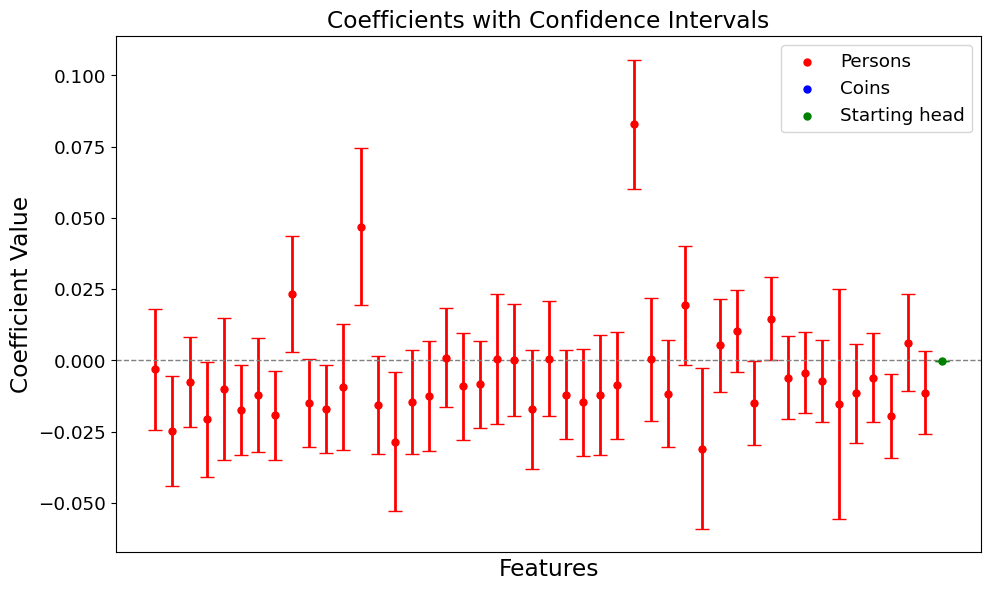

In [9]:
import re
# the introductory model 
result_WLS = result_WLS_2

coefficients = result_WLS.params
conf_int = result_WLS.conf_int()

# remove the constant coefficient : 
coefficients = result_WLS.params[1:]  # Exclude the first coefficient
conf_int = result_WLS.conf_int()[1:] 
conf_int_inf= list(conf_int[0])
conf_int_sup= list(conf_int[1])
feature_names = result_WLS.model.exog_names[1:]

# Determine colors based on the feature names
colors = [
    'red' if 'person' in feature else 'blue' if 'coin' in feature else "green"
    for feature in feature_names
]

# Create the plot
plt.figure(figsize=(10, 6))

# Clean the feature names
for i, (feature, coef, color) in enumerate(zip(feature_names, coefficients, colors)):
    plt.errorbar(
        x=i,
        y=coef,
        yerr=[[coef - conf_int_inf[i]], [conf_int_sup[i] - coef]],
        fmt='o',
        ecolor=color,  # Use the determined color for error bars
        color=color,   # Use the determined color for points
        capsize=5
    )

# Add a horizontal line at y=0
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)

# Create a legend
plt.scatter([], [], color='red', label='Persons')   # Red legend entry
plt.scatter([], [], color='blue', label='Coins')    # Blue legend entry
plt.scatter([], [], color='green', label='Starting head')  # Green legend entry
plt.legend(loc='upper right')

# Add labels and title
plt.xlabel('Features')
plt.xticks([])
plt.ylabel('Coefficient Value')
plt.title('Coefficients with Confidence Intervals')
plt.tight_layout()
plt.show()

# selected model is 1+C(person)+agg

<Figure size 800x600 with 0 Axes>

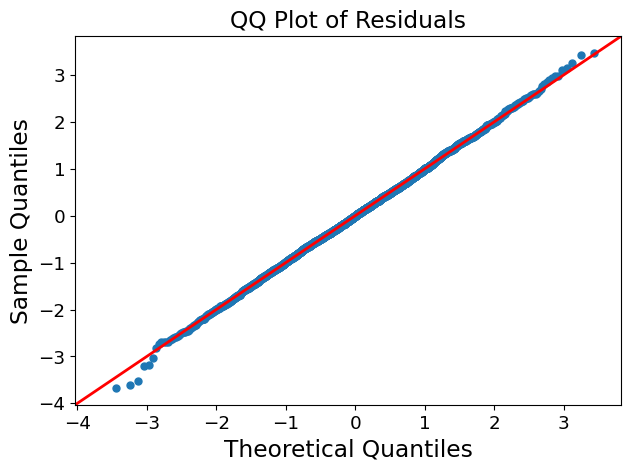

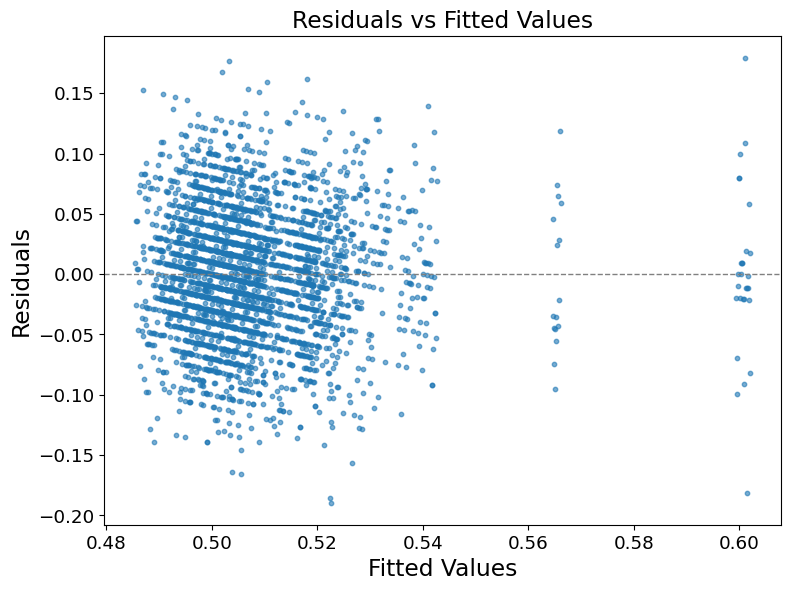

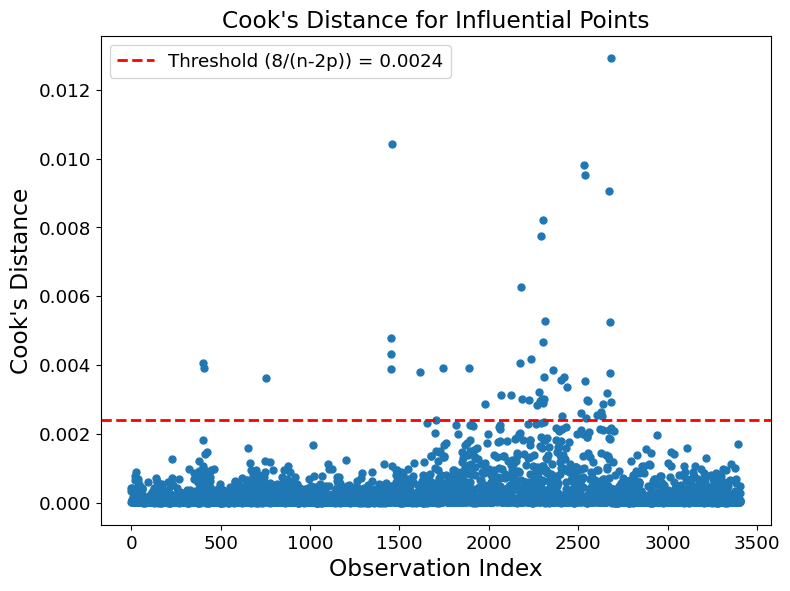

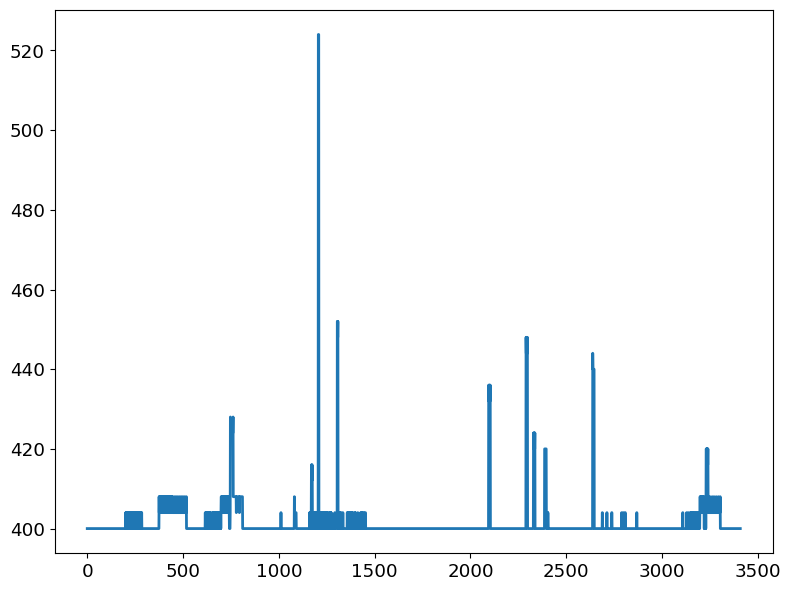

In [10]:
from statsmodels.stats.outliers_influence import OLSInfluence

WLS_model_complete = linear_model.WLS.from_formula(formula="(rom) ~ 1+C(person)+agg",weights=data_expanded["weights"]/np.mean(data_expanded["weights"]),  data=data_expanded) # Best LRT
result_WLS_complete = WLS_model_complete.fit()

# Extract residuals and fitted values
residuals_complete = result_WLS_complete.resid # actual values minus the predicted value
fitted_values_complete = result_WLS_complete.fittedvalues # ok predicted values 
standardized_residuals_complete = residuals_complete / np.std(residuals_complete) # standardized residuals
standardized_residuals_complete = result_WLS_complete.resid_pearson


# QQ Plot (Normality of residuals)
plt.figure(figsize=(8, 6))
sm.qqplot(residuals_complete, line='45', fit=True)
plt.title('QQ Plot of Residuals')
plt.show()

# Residuals vs Fitted Values
plt.figure(figsize=(8, 6))
plt.scatter(fitted_values_complete, residuals_complete, alpha=0.6,s=10)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

# --------------------------------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------------------------------

influence = OLSInfluence(result_WLS_complete)
p_complete = result_WLS_complete.df_model
n_complete = len(data_expanded)
cooks,y = influence.cooks_distance
threshold_complete = 8/(n_complete-2*p_complete)
#threshold_complete = 4/(n_complete)

# Plot Cook's Distance
plt.figure(figsize=(8, 6))
plt.scatter(np.arange(len(cooks)), cooks)  
plt.title("Cook's Distance for Influential Points")
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.axhline(y=threshold_complete, color='red', linestyle='--', label=f"Threshold (8/(n-2p)) = {threshold_complete:.4f}")
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(list(range(len(data_expanded["weights"]))),data_expanded["weights"])


#### Make the clean plot of the diagnostics : 

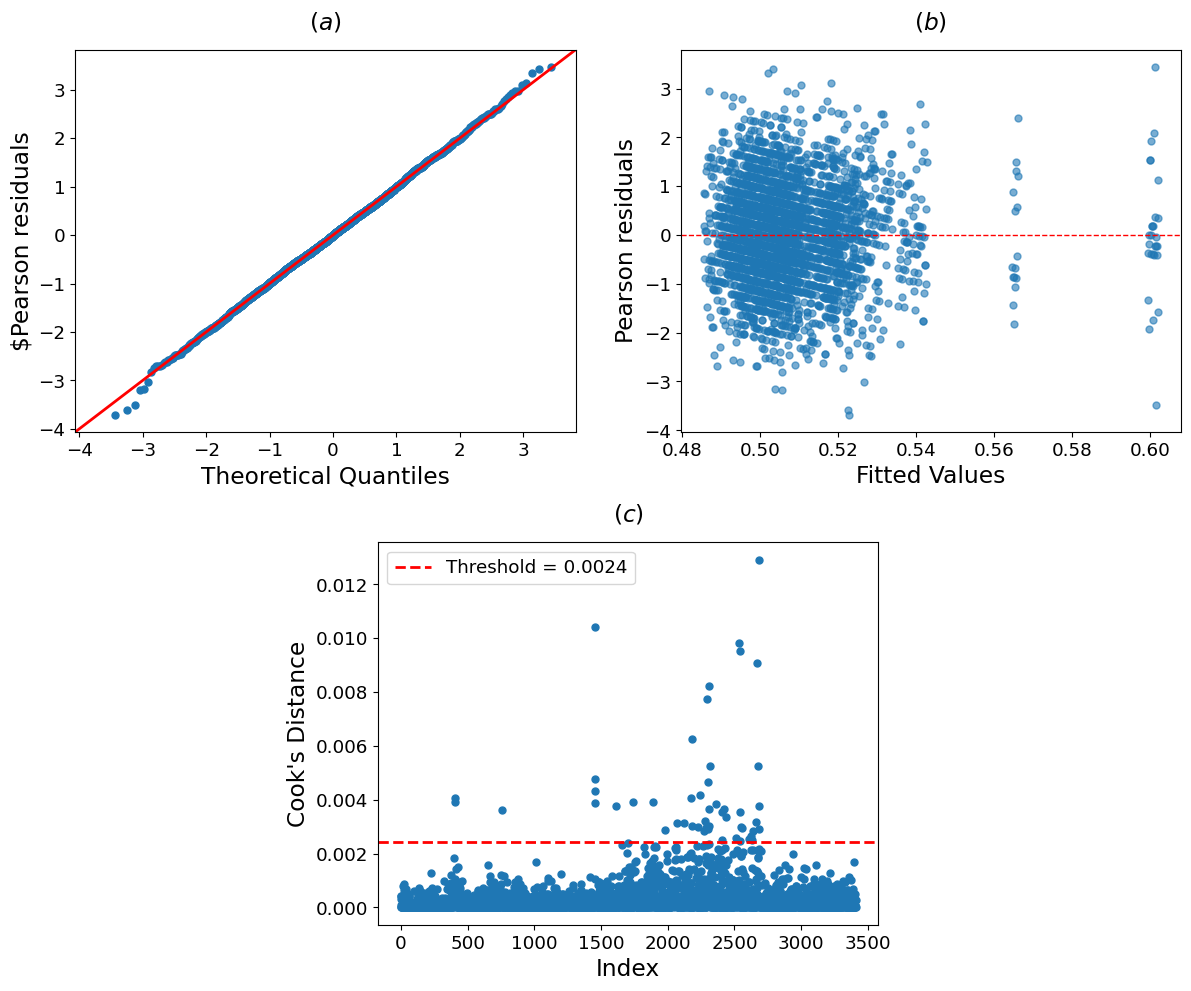

In [11]:
from statsmodels.api import qqplot
from matplotlib.gridspec import GridSpec

# Assume data_expanded and model are already defined
WLS_model_complete = sm.WLS.from_formula(
    formula="(rom) ~ 1 + person + agg", 
    weights=data_expanded["weights"]/np.mean(data_expanded["weights"]),  
    data=data_expanded 
)     

result_WLS_complete = WLS_model_complete.fit()

# Residuals and Fitted Values
residuals_complete = result_WLS_complete.resid
fitted_values_complete = result_WLS_complete.fittedvalues
standardized_residuals_complete = result_WLS_complete.resid_pearson

# Cook's Distance
influence = OLSInfluence(result_WLS_complete)
cooks, _ = influence.cooks_distance
p_complete = result_WLS_complete.df_model
n_complete = len(fitted_values_complete)
threshold_complete = 8 / (n_complete - 2 * p_complete)
#threshold_complete = threshold_complete / np.mean((data_expanded["weights"]))
#print(np.mean(residuals_complete**2))

# Create the figure with subplots
fig = plt.figure(figsize=(12, 10), layout='tight')

gs = GridSpec(2, 4, figure=fig, )
ax1 = fig.add_subplot(gs[0,0:2])
ax2 = fig.add_subplot(gs[0,2:])
ax3 = fig.add_subplot(gs[1,1:-1])

# QQ Plot (subplot 1)
qqplot(standardized_residuals_complete, line='45', ax=ax1, fit=True)
ax1.set_title('$(a)$', pad=15)
ax1.set_ylabel('$Pearson residuals')

# Residuals vs Fitted Values (subplot 2)
ax2.scatter(fitted_values_complete, standardized_residuals_complete, alpha=0.6)
ax2.axhline(0, color='red', linestyle='--', linewidth=1)
ax2.set_title('$(b)$', pad=15)
ax2.set_xlabel('Fitted Values')
ax2.set_ylabel('Pearson residuals')

# Cook's Distance (subplot 3)
ax3.scatter(range(len(cooks)), cooks)
ax3.axhline(threshold_complete, color='red', linestyle='--', label=f"Threshold = {threshold_complete:.4f}")
ax3.set_title("$(c)$", pad=15)
ax3.set_xlabel('Index')
ax3.set_ylabel("Cook's Distance")
ax3.legend()

# Adjust layout and show
plt.tight_layout()
plt.savefig('../figures/WLS_diagnostics.png', dpi=300)
plt.show()

In [12]:
# extract the only extreme cook :
influential_points = cooks > threshold_complete # Get the indices of the points with Cook's distance exceeding the threshold
points_qui_depassent = data_expanded[influential_points]

influential_data = points_qui_depassent[['person', 'coin', 'agg']]

print(len(influential_data)/len(data_expanded))

0.01496039894397184


In [13]:
# Extract the top 15 Cook's distances and their corresponding rows
top_cooks = data_expanded.iloc[np.argsort(cooks)[-15:][::-1]]
top_cooks = top_cooks[['person', 'coin', 'agg']]

# Print the results
#print(f"Points with excessive Cook's distance (greater than #{threshold_complete:.4f}):")
#print(influential_data)

print(f"Points with excessive Cook's distance the 15 biggest:")
print(top_cooks)

print()

Points with excessive Cook's distance the 15 biggest:
               person     coin  agg
2771        XiaoyiLin  0.20EUR   14
1544            irmaT     1EUR    7
2621       TianqiPeng     1EUR    7
2625       TianqiPeng  0.20EUR   11
2758        XiaoyiLin  0.50EUR    1
2392        JoycePang  0.50SGD    1
2377          JanYang  0.50EUR    2
2264          BohanFu  0.02EUR   20
2403        JoycePang  0.20EUR   12
2765        XiaoyiLin  0.50EUR    8
1540            irmaT     1EUR    3
2387          JanYang  0.20EUR   12
1541            irmaT     1EUR    4
2325  FranziskaAssion     1DEM   18
488           madlenH  0.50EUR   29



In [14]:
# table of number of throws per person : 
throws_per_person = data_expanded.groupby('person')['m'].sum().reset_index()
throws_per_person['ranking'] = throws_per_person['m'].rank(ascending=False, method='min').astype(int)
# table of average rom per person 
average_rom_per_person = data_expanded.groupby('person')['rom'].mean().reset_index()

throws_and_rom = pd.merge(throws_per_person, average_rom_per_person, on='person')
#print(throws_and_rom)

final_table = pd.merge(top_cooks, throws_and_rom, on='person')
final_table = final_table[['person','coin','agg','ranking']]

print(final_table)


             person     coin  agg  ranking
0         XiaoyiLin  0.20EUR   14       46
1             irmaT     1EUR    7       47
2        TianqiPeng     1EUR    7       41
3        TianqiPeng  0.20EUR   11       41
4         XiaoyiLin  0.50EUR    1       46
5         JoycePang  0.50SGD    1       43
6           JanYang  0.50EUR    2       45
7           BohanFu  0.02EUR   20       44
8         JoycePang  0.20EUR   12       43
9         XiaoyiLin  0.50EUR    8       46
10            irmaT     1EUR    3       47
11          JanYang  0.20EUR   12       45
12            irmaT     1EUR    4       47
13  FranziskaAssion     1DEM   18       34
14          madlenH  0.50EUR   29       19


## Plot the distribution of the coefficients etc...

Considering the  46  most common persons
Considering the  42  most common coins
Outlier number 1:  person[T.JanYang]
Outlier number 2:  person[T.TianqiPeng]
Outlier number 3:  person[T.adamF]
Outlier number 1:  coin[T.0.02EUR]


Text(0.5, 0.98, 'Coins coefs')

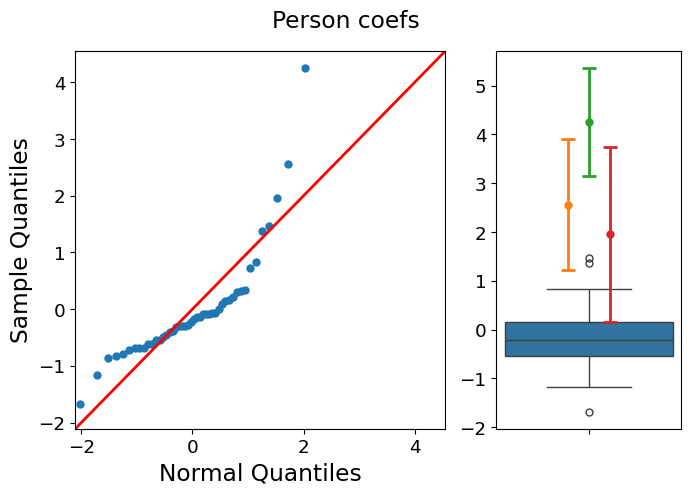

<Figure size 500x500 with 0 Axes>

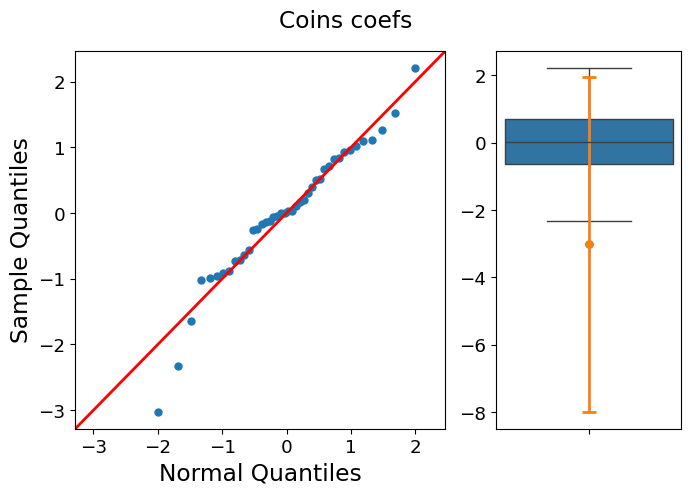

In [15]:


data, info = process_data('df-time-agg', keep_coins=1, keep_persons=1, drop_ingeborg=True)

# Assume data_expanded and model are already defined
WLS_model_full = sm.WLS.from_formula(
    formula="(rom) ~ 1 + person + coin + agg", 
    weights=data_expanded["weights"]/np.mean(data_expanded["weights"]),  
    data=data_expanded 
)     
result_WLS_full = WLS_model_full.fit()

# get coefficients associated with people main effects
coefs = result_WLS_full.params
ci_l = coefs - result_WLS_full.conf_int()[0] 
ci_u = result_WLS_full.conf_int()[1] - coefs
width = ci_u - ci_l

filt_person = coefs[coefs.index.str.match(r'^person\[T\.[^\]:]+\]$')]
filt_coin = coefs[coefs.index.str.match(r'^coin\[T\.[^\]:]+\]$')]
pattern_person = r'^person\[T\.(' + '|'.join(info['common_persons']) + r')\]$'
pattern_coin = r'^coin\[T\.(' + '|'.join(info['common_coins']) + r')\]$'
common_persons = filt_person[ filt_person.index.str.match( pattern_person ) ]
common_coins = filt_coin[ filt_coin.index.str.match( pattern_coin ) ]

def norm(x, mean=None, std = None, return_params=False):
    if mean is None or std is None:
        mean = x.mean()
        std = x.std()
    if return_params:
        return (x - mean) / std, mean, std
    return (x - mean) / std

def unorm(x, mean, std):
    return x * std + mean

print('Considering the ', common_persons.count(), ' most common persons')
print('Considering the ', common_coins.count(), ' most common coins')


fig, ax = plt.subplots( 1, 2, figsize=(7, 5), width_ratios=[1, .5])
sm.qqplot(norm(common_persons), line='45', ax=ax[0])
ax[0].set_xlabel('Normal Quantiles')
sb.boxplot(norm(common_persons), ax=ax[1])

outliers = ax[1].get_lines()[5].get_ydata() # I found this by inspecting the boxplot
n_person, mean_person, std_person = norm(common_persons, return_params=True)
plt.plot(np.nan, np.nan) # skip blue color in cycler by plotting nothing


pos = [-.1,0,.1]
k = 0
for element in outliers:
    if abs(element) in np.sort(np.abs(outliers))[:-3]:
        continue
    unorm_element = unorm(element, mean_person, std_person)
    ind = common_persons[abs(common_persons-unorm_element)<1.0e-10].index[0]
    plt.plot(0, element, marker='s', color='white', markersize=10)
    plt.errorbar(pos[k], element, yerr=norm(ci_u[f'{ind}'], mean=0.0, std=std_person), fmt='o', capsize=5, capthick=2)
    k += 1
    print(f'Outlier number {k}: ', ind)

plt.savefig('../figures/WLS-unusual_people.png')
fig.suptitle('Person coefs')

plt.figure(figsize=(5, 5))
fig, ax = plt.subplots( 1, 2, figsize=(7, 5), width_ratios=[1, .5])
sm.qqplot(norm(common_coins), line='45', ax=ax[0])
ax[0].set_xlabel('Normal Quantiles')
sb.boxplot(norm(common_coins), ax=ax[1])


outliers = ax[1].get_lines()[5].get_ydata()
n_coin, mean_coin, std_coin = norm(common_coins, return_params=True)
plt.plot(np.nan, np.nan) # skip blue color in cycler by plotting nothing
for i, element in enumerate(outliers):
    unorm_element = unorm(element, mean_coin, std_coin)
    ind = common_coins[abs(common_coins-unorm_element)<1.0e-10].index[0]
    plt.errorbar(0, element, yerr=norm(ci_u[f'{ind}'], mean=0.0, std=std_coin), fmt='o', capsize=5, capthick=2)
    print(f'Outlier number {i+1}: ', ind)

plt.savefig('../figures/WLS-unusual_coins.png')
fig.suptitle('Coins coefs')

#print(coefs)

# Plot of the big figure !

C:\Users\Tobia\AppData\Local\Temp\ipykernel_21852\2859135261.py:2: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.savefig('../figures/wls_resid_vs_covariates.png', dpi=300)
c:\Users\Tobia\miniconda3\envs\regression\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


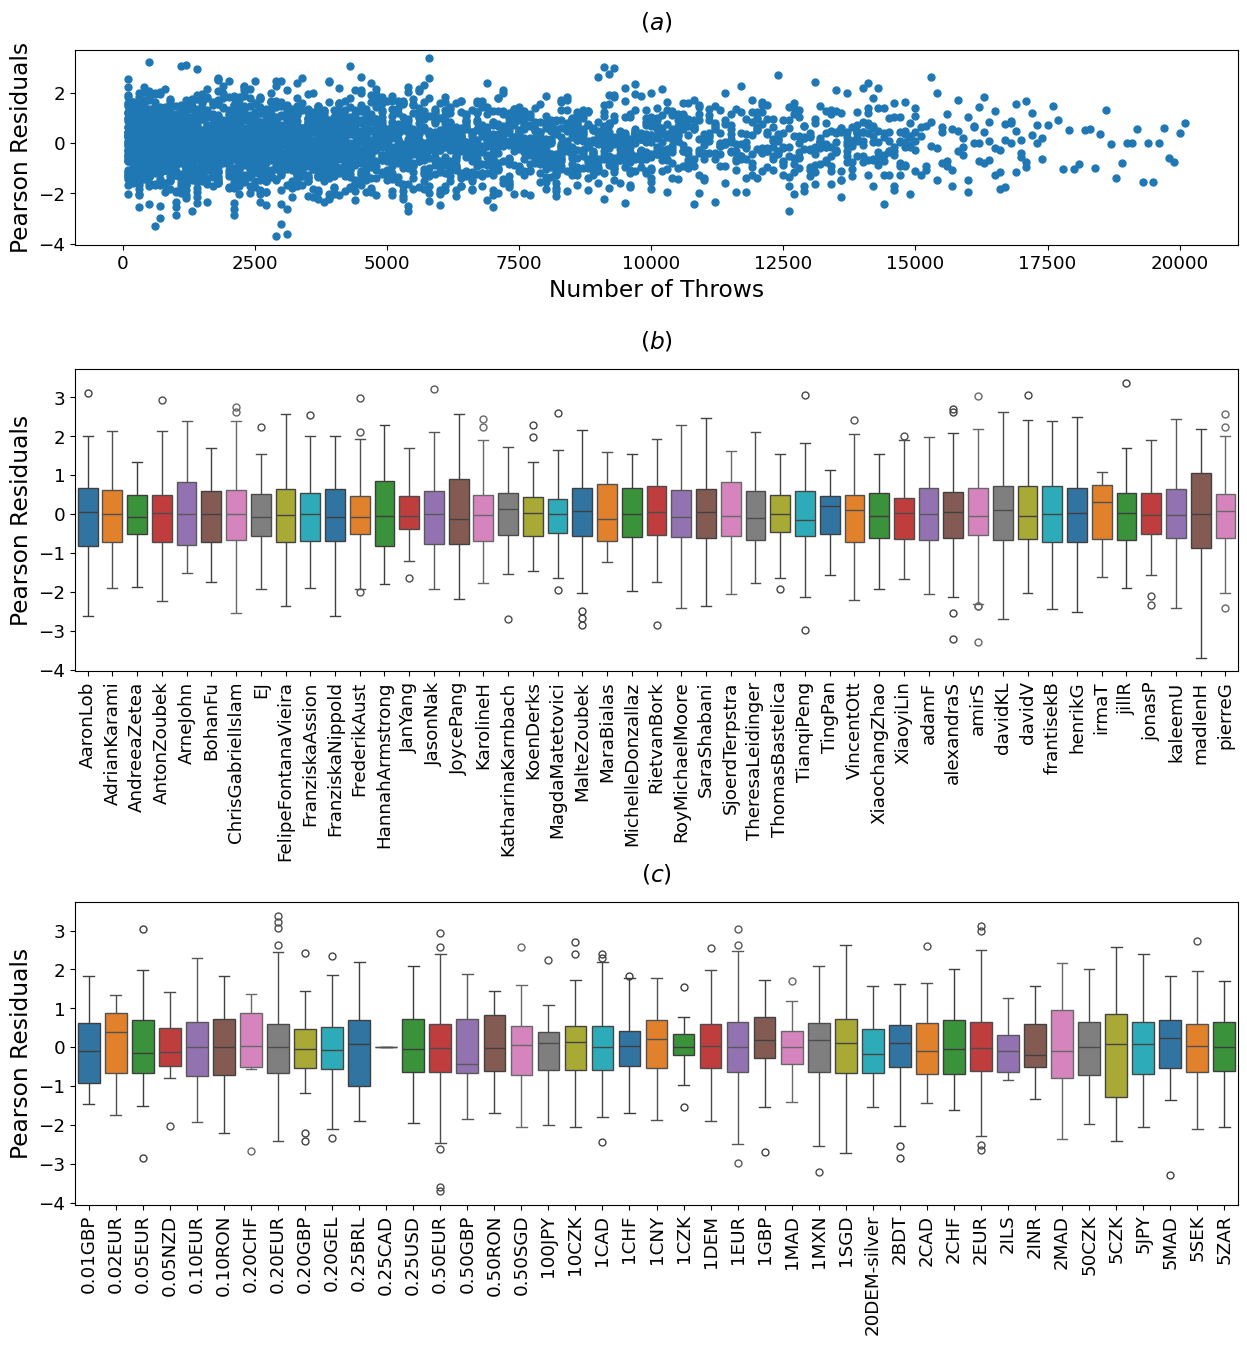

In [16]:
ax = residual_vs_covariate( result_WLS_4 , data , is_wls=True )
plt.savefig('../figures/wls_resid_vs_covariates.png', dpi=300)

### Plot the time evolution

0    0.523790
1    0.523659
2    0.523529
3    0.523399
4    0.523269
Name: up_ci, dtype: float64 0       0.523790
1       0.523659
2       0.523529
3       0.523399
4       0.523269
          ...   
3485    0.502910
3486    0.502820
3487    0.502731
3488    0.502642
3489    0.502553
Name: up_ci, Length: 3404, dtype: float64


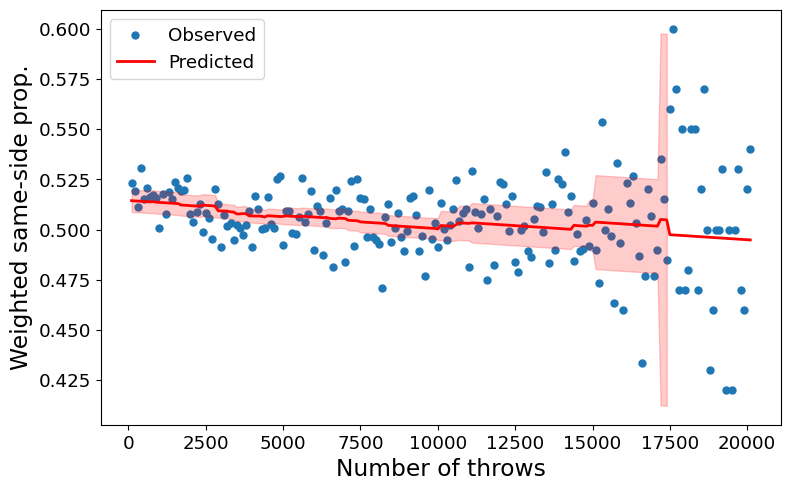

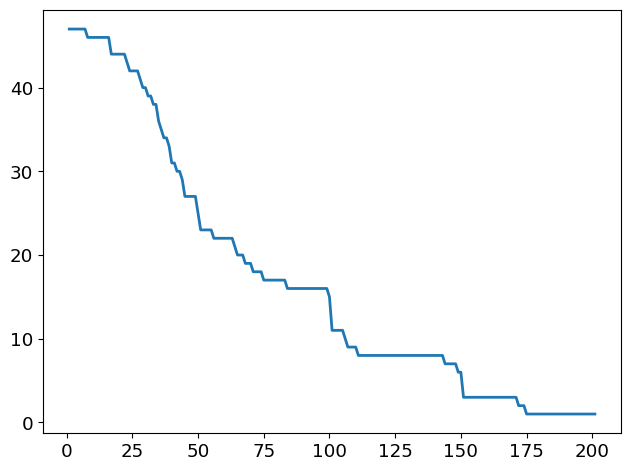

In [17]:
from scipy.stats import t

WLS_model_complete = sm.WLS.from_formula(
    formula="(rom) ~ 1 + person + agg", 
    weights=data_expanded["weights"]/np.mean(data_expanded["weights"]),  
    data=data_expanded 
)     

result_WLS_complete = WLS_model_complete.fit()

# Residuals and Fitted Values
coefficients = result_WLS_complete.params


prediction = result_WLS_complete.predict(data)
wheighted_prediction = (prediction * data['N_throws']).groupby(data['agg']).sum() / data['N_throws'].groupby(data['agg']).sum()
pred_se = prediction.groupby(data['agg']).std() / np.sqrt(data['N_throws'].groupby(data['agg']).count())

data['up_ci'] = result_WLS_complete.get_prediction().summary_frame()['mean_ci_upper']
print(data['up_ci'].head(), data['up_ci'].head(-5))
same_side = data.groupby('agg').agg({'same_side': 'sum'}).values
diff_side = data.groupby('agg').agg({'diff_side': 'sum'}).values 
observation = same_side / (same_side + diff_side)
cum_n_throws = 100*data['agg'].unique()

counts = data['N_throws'].groupby(data['agg']).count()
ind = np.min(np.where(counts == 1))
dfs = counts - 1
alpha = 0.05
t_factors = t.ppf(1 - alpha / 2, dfs)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
plt.scatter(cum_n_throws, observation, label='Observed')
plt.plot(cum_n_throws, wheighted_prediction, label='Predicted', color='red')
#plt.fill_between(cum_n_throws, low_ci, up_ci, color='red', alpha=0.2)
plt.fill_between(cum_n_throws[:ind], wheighted_prediction[:ind] - t_factors[:ind]*pred_se[:ind], \
                 wheighted_prediction[:ind] + t_factors[:ind]*pred_se[:ind], color='red', alpha=0.2)
plt.legend()
plt.xlabel('Number of throws')
plt.ylabel('Weighted same-side prop.')
plt.savefig('../figures/glm_learning_effects.png', dpi=300)


plt.figure()
plt.plot(counts)


person[T.AdrianKarami]          -0.003141
person[T.AndreeaZetea]          -0.024752
person[T.AntonZoubek]           -0.007531
person[T.ArneJohn]              -0.020633
person[T.BohanFu]               -0.009975
person[T.ChrisGabrielIslam]     -0.017376
person[T.EJ]                    -0.012077
person[T.FelipeFontanaVieira]   -0.019267
person[T.FranziskaAssion]        0.023426
person[T.FranziskaNippold]      -0.014908
person[T.FrederikAust]          -0.016927
person[T.HannahArmstrong]       -0.009420
person[T.JanYang]                0.046851
person[T.JasonNak]              -0.015590
person[T.JoycePang]             -0.028541
person[T.KarolineH]             -0.014494
person[T.KatharinaKarnbach]     -0.012502
person[T.KoenDerks]              0.000987
person[T.MagdaMatetovici]       -0.009129
person[T.MalteZoubek]           -0.008360
person[T.MaraBialas]             0.000641
person[T.MichelleDonzallaz]      0.000108
person[T.RietvanBork]           -0.017173
person[T.RoyMichaelMoore]        0

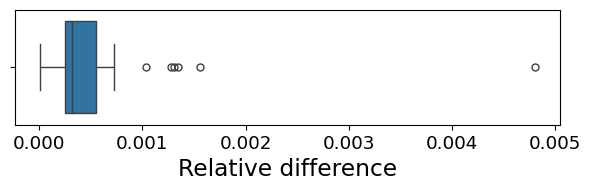

In [18]:
coef_WLS = coefficients
coef_WLS_df = coef_WLS.reset_index()

data, _ = process_data('df-time-agg', keep_coins=1, keep_persons=1, drop_ingeborg=True, drop_lonely=False)
__, results_person_time = deviance_analysis(data, 'same_side+diff_side~1+person+agg', 'person_time_glm', force=True)

person_time_coefs = results_person_time.params
pers_coefs = person_time_coefs[person_time_coefs.index.str.match(r'^person\[T\.[^\]:]+\]$')]
intercept = person_time_coefs['Intercept']

p_pers_zeroagg = np.exp(pers_coefs+intercept) / (1 + np.exp(pers_coefs+intercept))
p_intercept = np.exp(intercept) / (1 + np.exp(intercept))
p_pers_diff = p_pers_zeroagg - p_intercept
print(p_pers_diff)
p_pers_diff.loc["Intercept"] = p_intercept
p_pers_diff_df = p_pers_diff.reset_index()
merged_series = pd.concat([coef_WLS, p_pers_diff], axis=1)
merged_series = merged_series.drop(index="agg")
df_coefs = merged_series.reset_index()
df_coefs.columns = ['person','WLS', 'GLM']
df_coefs['differences'] = abs((df_coefs["WLS"]-df_coefs["GLM"])/df_coefs["WLS"])
#print(df_coefs)

plt.figure(figsize=(6,2))
sb.boxplot(df_coefs["differences"],orient='h')
plt.xlabel("Relative difference")
plt.savefig("../figures/parameter_differences_boxplot.png",dpi=300)

In [ ]:
# rank by rom : 

m_tot_person = data_expanded.groupby('person')['m'].sum().reset_index()
r_tot_person = data_expanded.groupby('person')['r'].sum().reset_index()
r_m_tot_person = pd.merge(m_tot_person,r_tot_person,on='person')
r_m_tot_person['rom'] = r_m_tot_person['r']/r_m_tot_person['m']
r_m_tot_person['rom'] = np.abs(r_m_tot_person['rom']-1/2)
r_m_tot_person['ranking'] = r_m_tot_person['rom'].rank(ascending=False, method='min').astype(int)

#r_m_tot_person['person'] = r_m_tot_person['person'].str.replace(r'^\d+\s+', '', regex=True)
r_m_tot_person['person'] = r_m_tot_person['person'].apply(lambda x: f"person[T.{x}]")
# raking vs differences 
final_table = pd.merge(df_coefs,r_m_tot_person,on= "person")
final_table = final_table.drop(columns=["GLM","WLS","m","r"])
final_table = final_table.sort_values(by = ["differences"],ascending=False)
print(final_table)

                           person  differences       rom  ranking
21    person[T.MichelleDonzallaz]     0.004805  0.017209       12
29              person[T.TingPan]     0.001555  0.018125       10
20           person[T.MaraBialas]     0.001343  0.018545        9
36              person[T.davidKL]     0.001311  0.026333        5
34           person[T.alexandraS]     0.001279  0.020821        7
38           person[T.frantisekB]     0.001033  0.004876       32
39              person[T.henrikG]     0.000725  0.003376       36
23      person[T.RoyMichaelMoore]     0.000716  0.017949       11
28           person[T.TianqiPeng]     0.000687  0.100714        1
37               person[T.davidV]     0.000679  0.005767       26
33                person[T.adamF]     0.000667  0.020476        8
44              person[T.madlenH]     0.000566  0.021978        6
45              person[T.pierreG]     0.000526  0.000400       45
42               person[T.jonasP]     0.000490  0.008203       19
19        